In [17]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from time import time
#Sklearn tools
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.model_selection import train_test_split
#Keras specials
import tensorflow as tf
from tensorflow.keras.models import Sequential, load_model, Model
from tensorflow.keras.layers import Dropout, Input, Dense, Concatenate, Lambda
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping, ModelCheckpoint
from tensorflow.keras.backend import round as k_round
from tensorflow.keras.losses import MeanSquaredError, BinaryCrossentropy
from sklearn.model_selection import train_test_split

In [18]:
df_x = pd.read_csv("Complete_BF_CPP_XY_Data.csv")

C:\Users\Omer\AppData\Local\Temp\ipykernel_20548\3693406356.py:1: DtypeWarning: Columns (0) have mixed types. Specify dtype option on import or set low_memory=False.
  df_x = pd.read_csv("Complete_BF_CPP_XY_Data.csv")


In [19]:
# Count NaN values per column
nan_counts = df_x.isna().sum()

# Total number of NaN values
total_nans = nan_counts.sum()

# Display columns with NaN values
nan_columns = nan_counts[nan_counts > 0]

# Display rows with NaN values
nan_rows = df_x[df_x.isna().any(axis=1)]

# Print results
print(f"Total NaN values: {total_nans}")
print("\nNaN count per column:")
print(nan_columns)

Total NaN values: 0

NaN count per column:
Series([], dtype: int64)


In [20]:
# Find positions of NaN values
nan_positions = np.where(df_x.isna())

# Convert positions into a readable DataFrame
nan_locations = pd.DataFrame({
    "Row Index": nan_positions[0],
    "Column Name": df_x.columns[nan_positions[1]]
})

print(nan_locations)

Empty DataFrame
Columns: [Row Index, Column Name]
Index: []


In [21]:
X = df_x.iloc[:, 1:5]  # X data (4 features: coordinate x-y, state, and county)
Y_layer1 = df_x.iloc[:, 5:27]  # Y1 data (22 features: site objective values)
Y2 = df_x.iloc[:, 27:]

binary_indices = [3, 5, 9, 10, 11, 12, 13, 21]
float_indices = [i for i in range(22) if i not in binary_indices]

YL = Y_layer1.iloc[:, float_indices]
YB = Y_layer1.iloc[:, binary_indices]

X_scaler = StandardScaler()
X_scaled = X_scaler.fit_transform(X)
YL_scaler = StandardScaler()
YL_scaled = YL_scaler.fit_transform(YL)
Y2_scaler = StandardScaler()
Y2_scaled = Y2_scaler.fit_transform(Y2)

Y1_combined = pd.concat([pd.DataFrame(YL_scaled), pd.DataFrame(YB)], axis=1)

# Combine Y1 and Y2 temporarily for consistent splitting
Y_combined = pd.concat([pd.DataFrame(Y1_combined), pd.DataFrame(Y2_scaled)], axis=1)

# Train-test split
X_train, X_test, Y_train, Y_test = train_test_split(X_scaled, Y_combined, test_size=0.2, random_state=42)

# Separate Y1 and Y2 back after splitting
Y1_train = Y_train.iloc[:, :Y1_combined.shape[1]]  # Extract Y1 part
Y2_train = Y_train.iloc[:, Y1_combined.shape[1]:].values  # Extract Y2 part

Y1_test = Y_test.iloc[:, :Y1_combined.shape[1]]  # Extract Y1 part
Y2_test = Y_test.iloc[:, Y1_combined.shape[1]:].values  # Extract Y2 part

# print(len(Y1_train.values[0])) # 22
# print(len(float_indices)) # 14

YL_train, YB_train = Y1_train.values[:, :len(float_indices)], Y1_train.values[:, len(float_indices):]
YL_test, YB_test = Y1_test.values[:, :len(float_indices)], Y1_test.values[:, len(float_indices):]


In [22]:
print(X_test[0,:])

[-0.15606184  0.61222438 -0.59649565 -0.60001106]


In [23]:
print(YL_test[0,:])

[-0.50211636 -0.92680966 -0.30736793 -0.86397954 -0.35133414 -0.63748399
 -0.85264835 -0.57426053  0.20627021 -0.54082277  0.00566712 -0.46805828
 -0.18774772  0.85601048]


In [24]:
print(YB_test[0,:])

[0. 1. 1. 1. 1. 0. 1. 1.]


In [25]:
print(Y2_test[0,:])

[ 0.61406174 -0.80452369 -0.80657463 -0.87345736 -0.63849199  0.98552883
 -0.8732135   0.99507988 -0.5799042   0.3940368   0.82714965  0.45363508
 -0.58402721  0.41925051 -0.64089488  0.41693887 -0.62372792 -0.74953046
 -0.67855653 -0.63543443 -0.89780629  0.53618529 -0.44230068]


In [26]:
assert not np.any(np.isnan(X_train)), "Training data contains NaN values"
assert not np.any(np.isnan(YL_train)), "YL_train contains NaN values"
assert not np.any(np.isnan(YB_train)), "YB_train contains NaN values"
print(np.unique(YB_train))

[0. 1.]


In [27]:
input_layer = Input(shape=(4,), name="Input_Layer")
x = Dense(800, activation='relu', name="Dense_Layer_1")(input_layer)
x = Dense(800, activation='relu', name="Dense_Layer_2")(x)
x = Dense(700, activation='relu', name="Dense_Layer_3")(x)
x = Dense(700, activation='relu', name="Dense_Layer_4")(x)
x = Dense(600, activation='relu', name="Dense_Layer_5")(x)
x = Dense(600, activation='relu', name="Dense_Layer_6")(x)
output_L = Dense(14, activation='linear', name="Output_Linear")(x)
output_B = Dense(8, activation='sigmoid', name="Output_Sigmoid")(x)
# output_B_binary = Lambda(lambda x: tf.cast(x > 0.5, tf.float32), name="Binarize_Layer")(output_B)

# Define the second neural network (Network 2)
# Network 2 takes the 4 original inputs and the 22 outputs from Network 1
concat_Y1 = Concatenate(name="Concatenate_Layer1")([output_L, output_B])
concat_inputs = Concatenate(name="Concatenate_Layer2")([input_layer, concat_Y1])
x2 = Dense(400, activation='relu', name="Dense_Layer_7")(concat_inputs)
x2 = Dense(350, activation='relu', name="Dense_Layer_8")(x2)
x2 = Dense(300, activation='relu', name="Dense_Layer_9")(x2)
output_2 = Dense(23, activation='linear', name="Output_Layer_2")(x2)

# Create a model that includes both networks
model = Model(inputs=input_layer, outputs=[output_L, output_B, output_2], name="Concatenated_Model")

# Compile the model
# We use two losses, one for each output (Network 1's and Network 2's predictions)
optimizer = Adam(learning_rate=1e-3, clipvalue=1.0)
model.compile(optimizer=optimizer, loss=['mse', 'binary_crossentropy', 'mse'])

# Print the model summary to verify the structure
model.summary()

Model: "Concatenated_Model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 Input_Layer (InputLayer)       [(None, 4)]          0           []                               
                                                                                                  
 Dense_Layer_1 (Dense)          (None, 800)          4000        ['Input_Layer[0][0]']            
                                                                                                  
 Dense_Layer_2 (Dense)          (None, 800)          640800      ['Dense_Layer_1[0][0]']          
                                                                                                  
 Dense_Layer_3 (Dense)          (None, 700)          560700      ['Dense_Layer_2[0][0]']          
                                                                                 

EXPLAIN THE LAYERS HERE, CONCATENATE_LAYER2 MEANS, 1 MEANS: OUT2 MEANS:

In [ ]:
start_time = time()
history = model.fit(X_train, [YL_train, YB_train, Y2_train], epochs=1000, batch_size=256)
print("Training took",(time()-start_time)/60,"minutes.")

Epoch 1/100
108/108 [==============================] - 10s 72ms/step - loss: 1.7326 - Output_Linear_loss: 0.6411 - Output_Sigmoid_loss: 0.3069 - Output_Layer_2_loss: 0.7846
Epoch 2/100
108/108 [==============================] - 5s 50ms/step - loss: 1.3315 - Output_Linear_loss: 0.4709 - Output_Sigmoid_loss: 0.1993 - Output_Layer_2_loss: 0.6613
Epoch 3/100
108/108 [==============================] - 5s 49ms/step - loss: 1.2269 - Output_Linear_loss: 0.4309 - Output_Sigmoid_loss: 0.1737 - Output_Layer_2_loss: 0.6223
Epoch 4/100
108/108 [==============================] - 5s 50ms/step - loss: 1.1776 - Output_Linear_loss: 0.4102 - Output_Sigmoid_loss: 0.1632 - Output_Layer_2_loss: 0.6041
Epoch 5/100
108/108 [==============================] - 5s 50ms/step - loss: 1.1309 - Output_Linear_loss: 0.3892 - Output_Sigmoid_loss: 0.1549 - Output_Layer_2_loss: 0.5869
Epoch 6/100
108/108 [==============================] - 5s 49ms/step - loss: 1.1060 - Output_Linear_loss: 0.3781 - Output_Sigmoid_loss: 0.15

In [29]:
losses = model.evaluate(X_test, [YL_test, YB_test, Y2_test])
# Predict using the test set
YL_pred, YB_pred, Y2_pred = model.predict(X_test)

# Inverse transform to rescale predictions back to original scale

yL_train_pred = YL_scaler.inverse_transform(model.predict(X_train)[0])
yL_train_true = YL_scaler.inverse_transform(YL_train)

y2_train_pred = Y2_scaler.inverse_transform(model.predict(X_train)[2])
y2_train_true = Y2_scaler.inverse_transform(Y2_train)

yL_test_pred = YL_scaler.inverse_transform(YL_pred)
yL_test_true = YL_scaler.inverse_transform(YL_test)

y2_test_pred = Y2_scaler.inverse_transform(Y2_pred)
y2_test_true = Y2_scaler.inverse_transform(Y2_test)

862/862 [==============================] - 4s 5ms/step


In [30]:
mae_yL_train = mean_absolute_error(yL_train_true, yL_train_pred)
mape_yL_train = np.mean(np.abs((yL_train_true - yL_train_pred) / yL_train_true)) * 100
mse_yL_train = mean_squared_error(yL_train_true, yL_train_pred)
rmse_yL_train = np.sqrt(mse_yL_train)
r2_yL_train = r2_score(yL_train_true, yL_train_pred)

# Calculate MAE, MAPE, MSE, RMSE, and R² for YL_test
mae_yL_test = mean_absolute_error(yL_test_true, yL_test_pred)
mape_yL_test = np.mean(np.abs((yL_test_true - yL_test_pred) / yL_test_true)) * 100
mse_yL_test = mean_squared_error(yL_test_true, yL_test_pred)
rmse_yL_test = np.sqrt(mse_yL_test)
r2_yL_test = r2_score(yL_test_true, yL_test_pred)

# Calculate MAE, MAPE, MSE, RMSE, and R² for Y2_train
mae_y2_train = mean_absolute_error(y2_train_true, y2_train_pred)
mape_y2_train = np.mean(np.abs((y2_train_true - y2_train_pred) / y2_train_true)) * 100
mse_y2_train = mean_squared_error(y2_train_true, y2_train_pred)
rmse_y2_train = np.sqrt(mse_y2_train)
r2_y2_train = r2_score(y2_train_true, y2_train_pred)

# Calculate MAE, MAPE, MSE, RMSE, and R² for Y2_test
mae_y2_test = mean_absolute_error(y2_test_true, y2_test_pred)
mape_y2_test = np.mean(np.abs((y2_test_true - y2_test_pred) / y2_test_true)) * 100
mse_y2_test = mean_squared_error(y2_test_true, y2_test_pred)
rmse_y2_test = np.sqrt(mse_y2_test)
r2_y2_test = r2_score(y2_test_true, y2_test_pred)

# Print the evaluation metrics in the specified order
print("Evaluation metrics for YL (train):")
print(f"MAE (YL train): {mae_yL_train}")
print(f"MAPE (YL train): {mape_yL_train}%")
print(f"MSE (YL train): {mse_yL_train}")
print(f"RMSE (YL train): {rmse_yL_train}")
print(f"R² (YL train): {r2_yL_train}")

print("\nEvaluation metrics for YL (test):")
print(f"MAE (YL test): {mae_yL_test}")
print(f"MAPE (YL test): {mape_yL_test}%")
print(f"MSE (YL test): {mse_yL_test}")
print(f"RMSE (YL test): {rmse_yL_test}")
print(f"R² (YL test): {r2_yL_test}")

print("\nEvaluation metrics for Y2 (train):")
print(f"MAE (Y2 train): {mae_y2_train}")
print(f"MAPE (Y2 train): {mape_y2_train}%")
print(f"MSE (Y2 train): {mse_y2_train}")
print(f"RMSE (Y2 train): {rmse_y2_train}")
print(f"R² (Y2 train): {r2_y2_train}")

print("\nEvaluation metrics for Y2 (test):")
print(f"MAE (Y2 test): {mae_y2_test}")
print(f"MAPE (Y2 test): {mape_y2_test}%")
print(f"MSE (Y2 test): {mse_y2_test}")
print(f"RMSE (Y2 test): {rmse_y2_test}")
print(f"R² (Y2 test): {r2_y2_test}")

Evaluation metrics for YL (train):
MAE (YL train): 209.9482858160222
MAPE (YL train): inf%
MSE (YL train): 733399.9348293572
RMSE (YL train): 856.3877245905369
R² (YL train): 0.7954662973909662

Evaluation metrics for YL (test):
MAE (YL test): 211.88929219665428
MAPE (YL test): inf%
MSE (YL test): 758490.2149394511
RMSE (YL test): 870.9134371104002
R² (YL test): 0.7654285235180793

Evaluation metrics for Y2 (train):
MAE (Y2 train): 0.012567603786502273
MAPE (Y2 train): inf%
MSE (Y2 train): 0.0004313519305882471
RMSE (Y2 train): 0.020769013712457485
R² (Y2 train): 0.6250939989689624

Evaluation metrics for Y2 (test):
MAE (Y2 test): 0.013174519978556055
MAPE (Y2 test): inf%
MSE (Y2 test): 0.0004753281423928066
RMSE (Y2 test): 0.021802021520785787
R² (Y2 test): 0.5880624851982761


C:\Users\Omer\AppData\Local\Temp\ipykernel_20548\4037580787.py:2: RuntimeWarning: divide by zero encountered in true_divide
  mape_yL_train = np.mean(np.abs((yL_train_true - yL_train_pred) / yL_train_true)) * 100
C:\Users\Omer\AppData\Local\Temp\ipykernel_20548\4037580787.py:9: RuntimeWarning: divide by zero encountered in true_divide
  mape_yL_test = np.mean(np.abs((yL_test_true - yL_test_pred) / yL_test_true)) * 100
C:\Users\Omer\AppData\Local\Temp\ipykernel_20548\4037580787.py:16: RuntimeWarning: divide by zero encountered in true_divide
  mape_y2_train = np.mean(np.abs((y2_train_true - y2_train_pred) / y2_train_true)) * 100
C:\Users\Omer\AppData\Local\Temp\ipykernel_20548\4037580787.py:23: RuntimeWarning: divide by zero encountered in true_divide
  mape_y2_test = np.mean(np.abs((y2_test_true - y2_test_pred) / y2_test_true)) * 100


In [31]:
from sklearn.metrics import accuracy_score

# Ensure YB_pred is binary (0 or 1)
YB_pred_binary = (YB_pred >= 0.5).astype(int)

# List to store accuracies for each column
accuracies = []

# Loop through each column in Y2_test (assumed to be a DataFrame)
for i in range(YB_test.shape[1]):
    # Use .iloc to select the i-th column of Y2_test and YB_pred_binary
    accuracy = accuracy_score(YB_test[:, i], YB_pred_binary[:, i])
    accuracies.append(accuracy)

# Create a DataFrame with accuracies
accuracy_df = pd.DataFrame({
    'Column': [f'Column_{i+1}' for i in range(YB_test.shape[1])],
    'Accuracy': accuracies
})

print(accuracy_df)

     Column  Accuracy
0  Column_1  1.000000
1  Column_2  0.997535
2  Column_3  0.978103
3  Column_4  0.916183
4  Column_5  0.993329
5  Column_6  0.959832
6  Column_7  0.937065
7  Column_8  0.959687


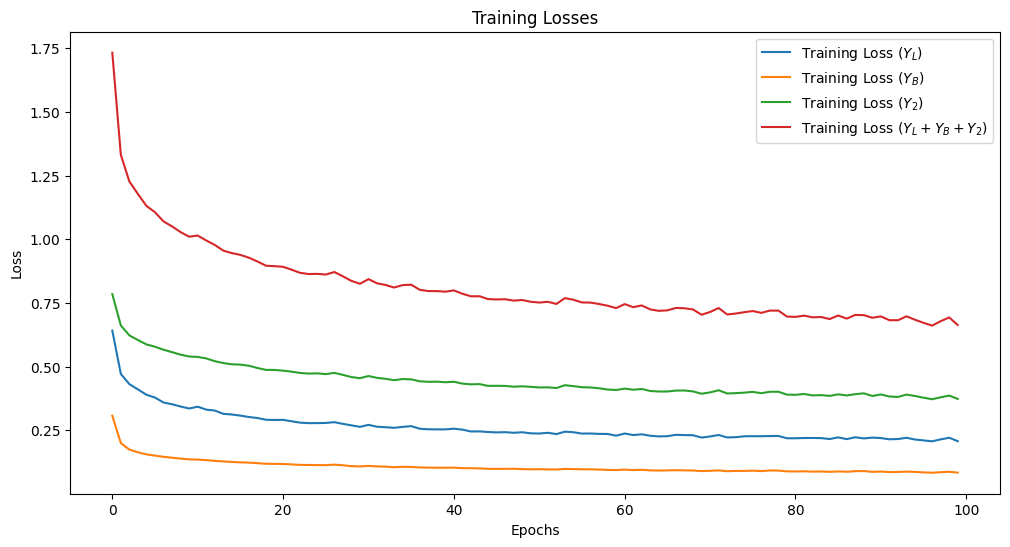

In [32]:
# Extract loss values from history
train_loss_yl = history.history['Output_Linear_loss']
train_loss_yb = history.history['Output_Sigmoid_loss']
train_loss_y2 = history.history['Output_Layer_2_loss']
total_loss = history.history['loss']

# Plot training losses
plt.figure(figsize=(12, 6))
plt.plot(train_loss_yl, label=r'Training Loss ($Y_{L}$)')
plt.plot(train_loss_yb, label=r'Training Loss ($Y_{B}$)')
plt.plot(train_loss_y2, label=r'Training Loss ($Y_{2}$)')
plt.plot(total_loss, label=r'Training Loss ($Y_{L} + Y_{B} + Y_{2}$)')
plt.title('Training Losses')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.savefig('training_losses.png', dpi=300, bbox_inches='tight')
plt.show()
